In [1]:
# tampering with the kwd file on passaro
# the /experiment folder is on the ssd of passaro (/usr/local/experiment/raw_data)
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
import glob
import errno    
import os
import shutil as sh
import yaml
import logging

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes'), 
                                     'gentner', 
                                     'earneodo', 
                                     'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    cube_experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    store_experiment_folder = os.path.join('/Data/bci_zf/')
    experiment_folder = os.path.join('/usr/local/experiment')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

#import soundtools as st
from scipy.io import wavfile
from swissknife.bci.core import expstruct as et
from swissknife.bci import supersession as ss
from swissknife.bci import stimalign as sa
from swissknife.bci.core.file import h5_functions as h5f

logger.info('All modules loaded')

2017-05-09 16:23:55,512 root         INFO     Computer: passaro
2017-05-09 16:23:55,537 root         INFO     All modules loaded


In [2]:
from swissknife.streamtools import streams as st

In [3]:
bird_id = 'z034'
sess_day = 'anesth_surface_depth_2017-03-10_16-30-53'
sess_day = 'anesth_surface_deep_2017-04-21_16-01-36'
depth = '650'
raw_location = 'rw'
# Make the super session and gather the list of sessions
# get the sessions list of files
raw_data_folder = et.file_names(bird_id)['folders'][raw_location]
sessions = glob.glob(os.path.join(raw_data_folder, sess_day + '*' + str(depth)))
day_par_file_path = os.path.join(sessions[0], et.file_names(bird_id)['structure']['par'])


In [4]:
(os.path.join(raw_data_folder, sess_day + '*' + str(depth)))

'/mnt/cube/earneodo/bci_zf/raw_data/z034/anesth_surface_deep_2017-04-21_16-01-36*650'

In [5]:
sessions

['/mnt/cube/earneodo/bci_zf/raw_data/z034/anesth_surface_deep_2017-04-21_16-01-36_650']

In [6]:
kwd_file_path = os.path.join(sessions[0], 'experiment1_100.raw.kwd')
dset = h5f.get_data_set(kwd_file_path, 0)

2017-05-09 16:23:57,950 root         DEBUG    H5 file: <HDF5 file "experiment1_100.raw.kwd" (mode r)>
2017-05-09 16:23:57,951 root         DEBUG    Getting dataset from rec 0


In [10]:
s_f = 30000
kwd_file_path

'/mnt/cube/earneodo/bci_zf/raw_data/z034/anesth_surface_deep_2017-04-21_16-01-36_650/experiment1_100.raw.kwd'

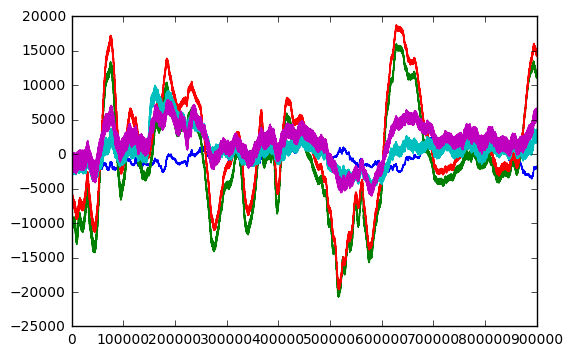

In [39]:
all_data = dset[:900000, 75:80];
plt.plot(all_data)

In [41]:
import scipy.signal as sg

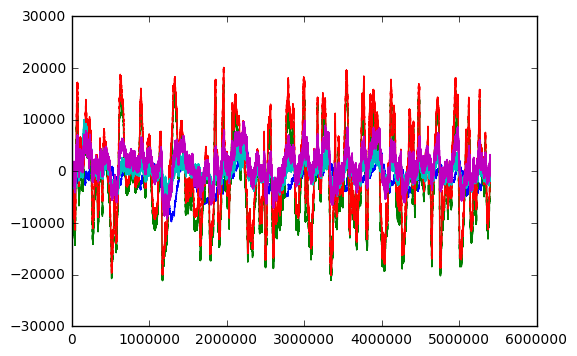

In [40]:
one_chan = h5f.load_table_slice(dset, np.arange(30000*180), np.arange(75, 80))
plt.plot(one_chan)

In [81]:
def primes(n):
    primfac = []
    d = 2
    while d*d <= n:
        while (n % d) == 0:
            primfac.append(d)  # supposing you want multiple factors repeated
            n //= d
        d += 1
    if n > 1:
       primfac.append(n)
    return primfac


def decimate_by_parts(x, q_list, *args, **kwargs):
    try:
        q = q_list.pop()
        z = sg.decimate(x, q, *args, **kwargs)
        y = decimate_by_parts(z, q_list, *args, **kwargs)
    except IndexError as ierr:
        if 'empty' in ierr.args[0]:
            y = x
        else:
            raise
    return y


def decimate(x, q, *args, **kwargs):
    q_list = primes(q)
    return decimate_by_parts(x, q_list, *args, **kwargs)

In [82]:
primes(10)

[2, 5]

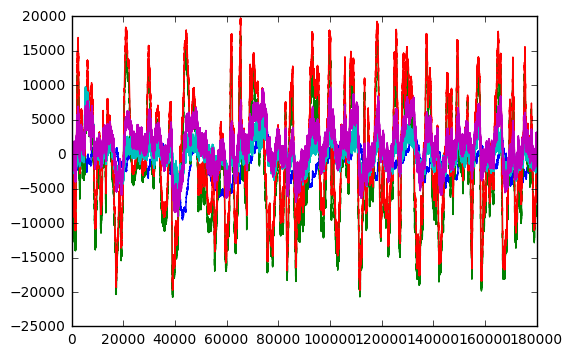

In [83]:
decim_data = decimate(one_chan, 30, axis=0)
decim_data.shape
plt.plot(decim_data)

In [69]:
decim_data

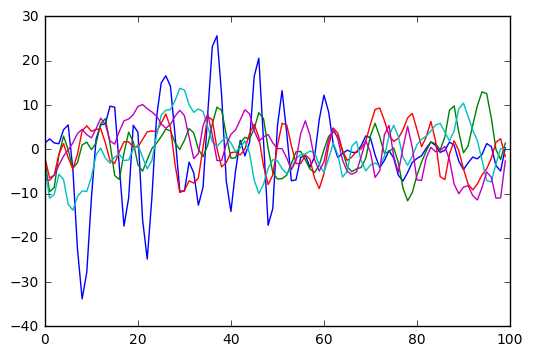

In [32]:
plt.plot(sp.apply_butter_bandpass(all_data[609700:609800], lfp_filter_pars));

In [11]:
from swissknife.streamtools import spectral as sp

def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s


def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []
    bad_frames = []
    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        try:
            one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                           s_f,
                                           dtype=np.float),
                                 np.array(chan_list),
                                 [start, start + span])
            frames.append(one_frame)
        except AssertionError:
            logger.warning('Frame out of bounds [{0}:{1}]'.format(start, start+span))
            bad_frames.append(i_start)
    return frames, np.delete(starts, bad_frames), np.delete(recs_list, bad_frames)

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames

def gather_all_frames(bird_id, sess_id, viz_set, stim_name='bos_tag'):
    exp_pars = et.get_parameters(bird_id, sess_id)
    f_n = et.file_names(bird, sess)


    
    
    stim_id = et.stim_id(exp_pars, stim_name)
    stim_file_path = et.file_path(f_n, 'ss', 'sng')
    with h5py.File(stim_file_path, 'r') as stim_file:
        stim = evt.Song(stim_id, stim_file)    
        starts = stim.get_start()
        recs = stim.get_rec()

    stimm_path = os.path.join(f_n['folders']['stim'], viz_set['stim_sess'], 
                      exp_par['search_motiff']['motiff_patterns'][stim_name])
    stim_chunk = st.Chunk(st.WavData2(m_path))
    
    before = viz_set['before_samp']
    after = viz_set['after_samp']
    with et.open_kwd(bird_id, sess_id) as kwd_f:
        v_frames, v_starts, v_recs = collect_frames(starts-before, before+after+stim_chunk.samples, 
                            s_f, 
                            kwd_f, recs, viz_set['channels'])
    
    return v_frames, v_starts, v_recs, stim_chunk

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt


lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

lfp_filter_band = [300, 7500]

lfp_filter_pars = sp.make_butter_bandpass(s_f, lfp_filter_band[0], lfp_filter_band[1])


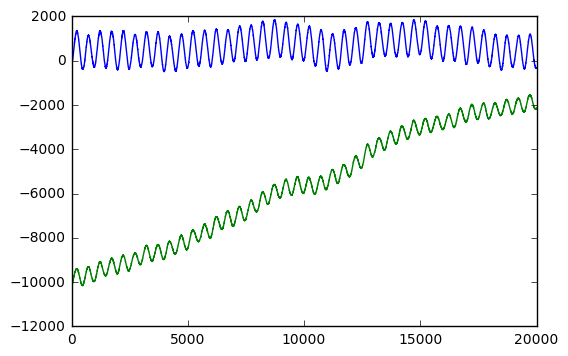

In [38]:
all_data = dset[280000:300000, 78]
plt.plot(all_data)
plt.plot(dset[280000:300000, 77])

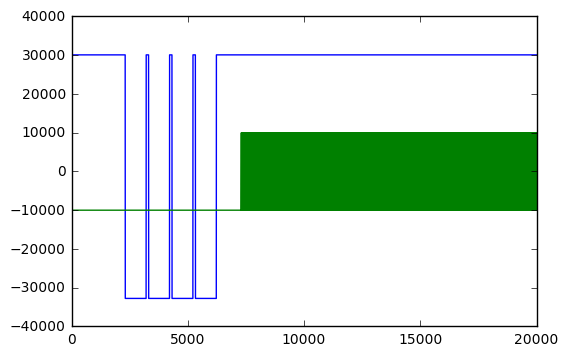

In [132]:
all_data = dset[280000:300000, 104]
tag = dset[280000:300000, 103]

mark = np.ones_like(tag)
mark[tag<0]=-1

plt.plot(all_data)
plt.plot(mark*10000)

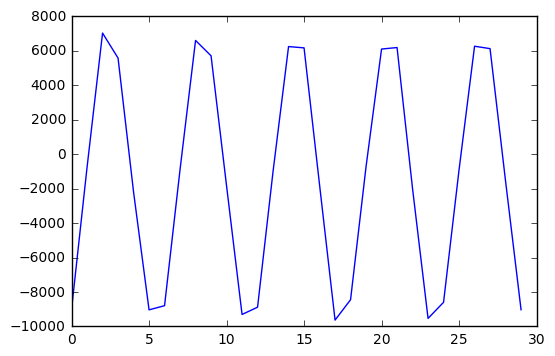

In [124]:
mark = np.ones_like(tag)
mark = mark*tag
plt.plot(mark[10000:10030])

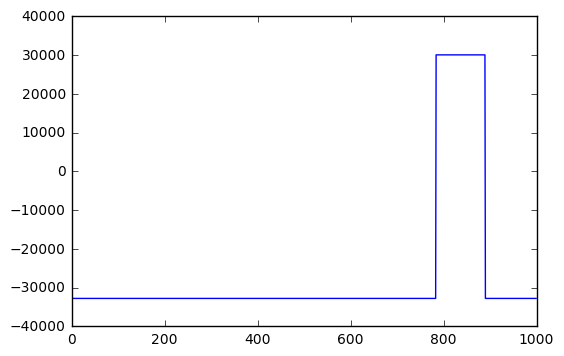

In [22]:
plt.plot(all_data[270000:271000])

In [ ]:
some_data = h5f.load_table_slice(dset, np.arange(120000))

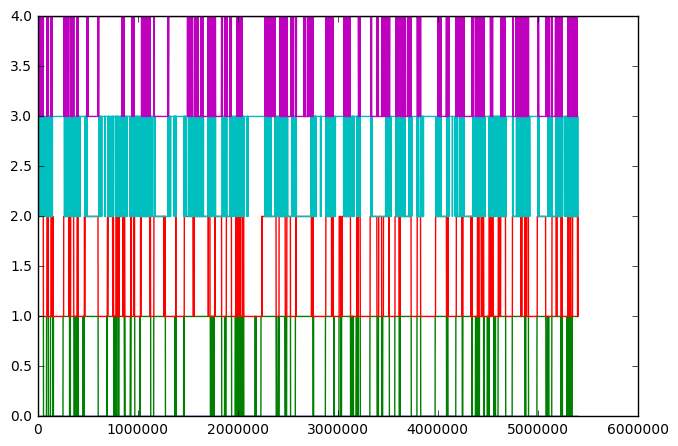

In [37]:
one_chan = h5f.load_table_slice(dset, np.arange(30000*180), np.arange(75, 80))
st.plot_array(one_chan);

In [35]:
one_chan.shape

(5400000, 5)

In [15]:
st.plot_array

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

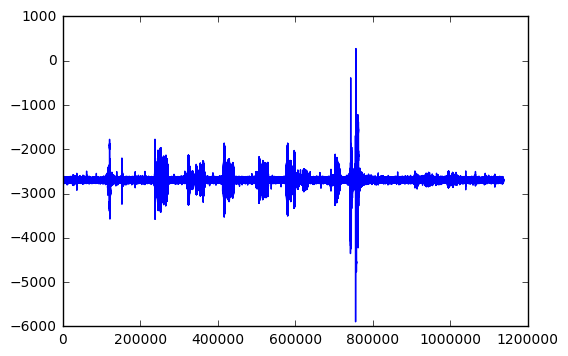

In [13]:
# view the mic chan
mic_chan = 35
mic_stream = dset[:, mic_chan]
plt.plot(mic_stream);

#save it 
mic_wav_path = os.path.join(os.path.split(kwd_file_path)[0], 'mic_chan.wav')
wavfile.write(mic_wav_path, 30000, mic_stream)

In [32]:
wavfile.write?

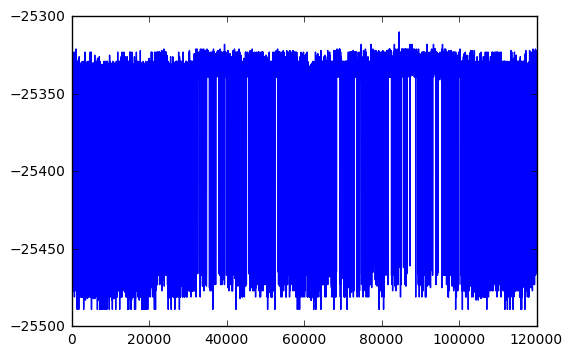

In [13]:
plt.plot(all_data[:,34])

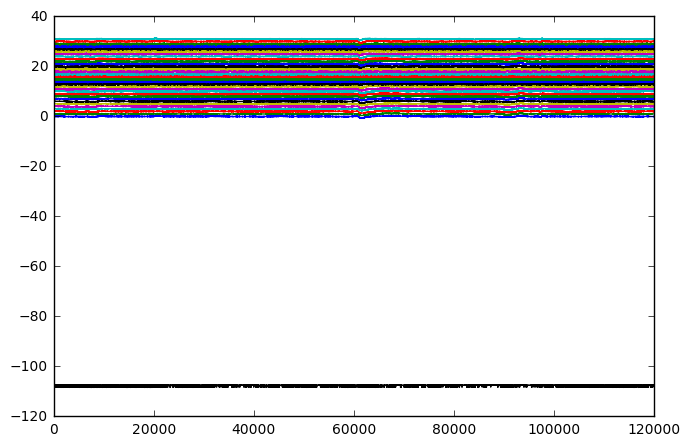

In [17]:
reload(st)
st.plot_array(all_data[:,:36].astype(np.float));

In [22]:
bird_id = 'testing'
sess_day = 'widepatch_2017-02-02'
depth = '0'
raw_location = 'raw'
# Make the super session and gather the list of sessions
# get the sessions list of files
raw_data_folder = et.file_names(bird_id)['folders'][raw_location]
sessions = glob.glob(os.path.join(raw_data_folder, sess_day + '*' + str(depth)))
day_par_file_path = os.path.join(sessions[0], et.file_names(bird_id)['structure']['par'])
all_ctrl_data = dset[80000:200000,:32]

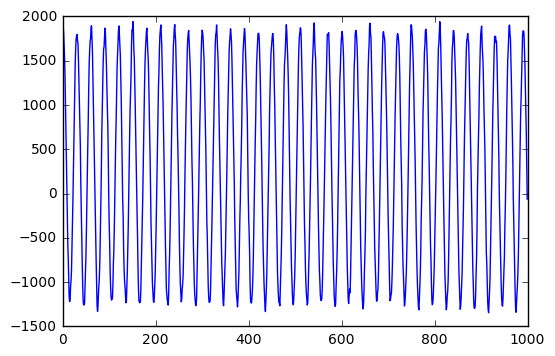

In [25]:

plt.plot(all_ctrl_data[20000:21000, 2])

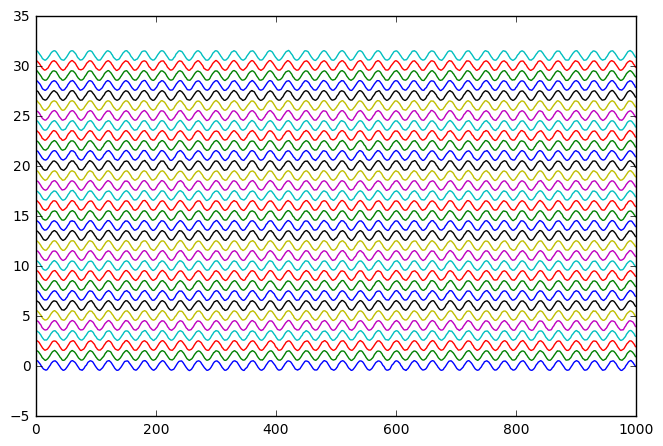

In [41]:
st.plot_array(all_ctrl_data[20000:21000, :].astype(np.float));